# Predictive Maintenance

### Author: Felipe Marcelino

### Context

In this assignment, you will analyze sensor data from a critical piece of equipment aboard an Floating Production, Storage, and Offloading (FPSO) vessel. FPSOs are pivotal in offshore oil and gas operations. Ensuring the reliability of onboard equipment is essential to prevent operational disruptions, safety risks, and costly downtime.

### Data 

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:

**Cycle**: Sequential identifier of measurement cycles. <br>
**Preset_1** & **Preset_2**: Variables that control a specific operating point of the machine. <br>
**Temperature**: Temperature recorded in the equipment. <br>
**Vibrations (X, Y & Z)**: Vibrations along the machine's axes. <br>
**Frequency**: Operating frequency of the machine. <br>
**Fail**: Variable indicating whether the machine is in a failure state at the given timestamp. <br>

 Ther are in total of 800 rows varying each one of the presets with the respectives values for **temperature**, **vibrations**, **frequency** and the label **fail**. Dataset does not contain any null values on the columns

**Fail Rate** is 8,25%

### Methdology 

The following sentences are the steps applied on the problem:
- Dataset summary: Statistical summaries (mean, percentiles, etc) were computed to indentify distribution, outliers, and imbalance.
- Visual Analysis
    - Univarite: Histograms/boxplots for variables like temperature and vibration to detect skewness or anomalie
    - Bivariate: Heatmap, lineplot, boxplots to explore relationships between features and the target (Fail)
- Feature Engineering:
    - Temporal Features:
        - Rolling Statistics: Computed rolling means/standard deviations
        - Lag Features: Past values to model temporal dependencies
    - Vibration Magnitude: Aggregate mutli-axis vibrations into a single metric
    - Target Encoding: Time-aware encoding for categorical presets to avoid data leakage
- Statistical Testing:
    - Chi-square test: Assessed assocations between **Preset_1/Preset_2** and **Fail**. 
- Create plots to get insights about univariate and bivariate analysis
- Modeling:
    - Train/test Split: Sequential split (no shuffling) to respect time-series integrity. For example, cycles 1–640 for training, 641–800 for testing.
    - Algorithm: LightGBM was chosen for its speed and efficiency with temporal data
    - PR-AUC was selected because of imbalanced dataset for positive class. In addition, we want to control threshold to manipulate false positive and false negative
- Interpretability:
   - SHAP Values:  Used to calculate the feature importance performance 
- Forecast Horizon:
    - Testing 3/5/10-cycle predictions and see which one has better trade-off between metrics.
- Teste model inference time
    - Create a synthetic batch dataset a simulate inference time for the batch and average for one sample.

### Conclusion 

The model achieves the PR-AUC of 0.44 and AUC-ROC of 0.82. The time series regarding the temperature, vibrations and frequency seems to be stationary without trend an seazonal features. The most correlated feature with the target (Fail) is VibrationY, howerver, the most important features for the model are rolling and lag features. The model used here to train and test the dataset is LightGBM because of it faster iteration on training and inference. Related to predict the future, we tested three values, predict 3,5,10 cycles ahead of the current time. The best one is 3 cycles, more closer to the future but without too much time to act. Model inference time is approximately 1 .ms 

## Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import shap
import warnings
import timeit
from scipy.stats import chi2_contingency
from typing import Union
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')

## Variables

In [35]:
# Group columns based on logic 
FEATURES: list = ["Temperature", "Pressure", "VibrationX",  "VibrationY", "VibrationZ", "Frequency"]
PRESETS: list = ["Preset_1","Preset_2"] # Can be a feature as well
TARGET: str = "Fail"
TIMESTAMP: str = "Cycle"
WINDOWS_SIZE_ROLLING: list = [3, 7, 10] # Modify WINDOWS_MIN_PERIOD as well. They have the same length
WINDOWS_MIN_PERIOD = [None, None, None] 
WINDOWS_SIZE_LAG: list = [1,2,3,5]
FUTURE_TARGET: str = "Fail_Future"
BATCH_INFERENCE_SIZE = 10000 # Used to test model inference time 
C: int = 3 # How much cycles in the future we want predict our target. 
TEST_SIZE = 0.2
THRESHOLD = 0.10 # Threshold related to output of the model. Will be 1 if >= threshold 
PRESET_LAG = True # Create preset lag features or not
SEED = 42
PARAMS: dict = { # Model's Hyperparametes 
    "boosting": "gbdt",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "seed": SEED,
    "data_sample_strategy": "goss",
}

## Definitions

In [4]:
def create_rolling_feature(df: pd.DataFrame, column: str, func: str, window_size: int, min_periods: int = None):
    """
    Create rolling mean/std features in a pandas DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column (str): Column name to calculate rolling features from
    func (str): 'mean' or 'std' for rolling statistic
    window_size (int): Size of the rolling window
    min_periods (int): minimum periods for windows rolling
    
    Returns:
    pd.DataFrame: DataFrame with new rolling feature column
    
    """
    
    # Input validation
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    if func not in ['mean', 'std', 'var']:
        raise ValueError("Function must be 'mean', 'std' or 'var'")
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Window size must be a positive integer")


    # Create new column name
    new_col = f"{column}_rolling_{func}_{window_size}"
    
    # Calculate rolling feature
    if func == 'mean':
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).mean()
    elif func == 'std':
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).std()
    else:
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).var()
        
    return df

def create_lag_feature(df: pd.DataFrame, column: str, lag_size: int = 1, fill_value: Union[int,float] = None, groupby: str = None):
    """
    Create lag features with optional groupby functionality
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column (str): Column name to create lag from
    lag_size (int): Number of periods to shift (default: 1)
    fill_value: Value to use for missing values (default: NaN)
    groupby (list/str): Column(s) to group by for group-specific lags
    
    Returns:
    pd.DataFrame: DataFrame with new lag feature column
    """
    
    # Input validation
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    if not isinstance(lag_size, int) or lag_size <= 0:
        raise ValueError("Lag size must be a positive integer")
    if groupby is not None:
        groupby = [groupby] if isinstance(groupby, str) else groupby
        missing = [col for col in groupby if col not in df.columns]
        if missing:
            raise ValueError(f"Groupby columns {missing} not found in DataFrame")

    # Create descriptive column name
    group_suffix = f"_by_{'_'.join(groupby)}" if groupby else ""
    new_col = f"{column}_lag_{lag_size}{group_suffix}"
    
    # Create lag feature
    if groupby:
        # Group-specific lag
        df[new_col] = df.groupby(groupby)[column].shift(lag_size)
    else:
        # Global lag
        df[new_col] = df[column].shift(lag_size, fill_value=fill_value)
    
    # Handle fill value if specified
    if fill_value is not None:
        df[new_col] = df[new_col].fillna(fill_value)
    
    return df

def time_aware_target_encoding(df: pd.DataFrame, column: str):
    """
    Create time aware target features. It uses on the first N values to create target encoding.
    In that way it avoid data leakage using feature values to encoding the past.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame
    column (str): Column name to create target encoding
    
    Returns:
    pd.DataFrame: DataFrame with new lag feature column
    """    

    new_column = f"{column}_target_encoded"

    df[new_column] = (
    df.groupby(column)[TARGET]
    .expanding(min_periods=1)  # Use expanding window
    .mean()
    .shift(1)  # Exclude current row to prevent leakage
    .reset_index(drop=True))

    return df 

In [5]:
def lgb_train_test(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.2, params: dict = None, threshold: float = 0.5):
    """
    Train/test procedure for LightGBM classification with ROC-AUC evaluation
    
    Parameters:
    model (Object): A model to train
    X (pd.DataFrame): Features dataframe
    y (pd.Series): Target variable
    test_size (float): Proportion of data for testing (default: 0.2)
    params (dict): LightGBM parameters (optional)
    threshold (float): Threshold for the output
    
    Returns:
    tuple: (model, test_preds, X_test, y_test, roc_auc, metrics_dict)
    """

     # Train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, shuffle=False)
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False, reference=train_data)
    
    # Train model with early stopping
    model = lgb.train(
        params,
        train_set=train_data,
        valid_sets=[train_data, test_data],
        valid_names=['train', 'test'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(50)
        ]
    )
    
    # Generate predictions
    test_preds = model.predict(X_test, num_iteration=model.best_iteration)

    # Binarizying output probability based on threshold 
    test_preds_class = (test_preds >= threshold).astype(int)

    
    # Calculate metrics
    #------------------
    # Calculate PR-AUC
    pr_auc = average_precision_score(y_test, test_preds)
    # Calculate precision and recall for curve
    precision, recall, _ = precision_recall_curve(y_test, test_preds)
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, test_preds)
    roc_auc = roc_auc_score(y_test, test_preds)
    # Calculate Accuracy
    acc = accuracy_score(y_test, test_preds_class)
    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(y_test, test_preds_class)

    lgb.Booster.save_model(model, "booster.txt")
    
    metrics_dict = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'accuracy': acc,
        'confusion_matrix': conf_matrix,
    }
    
    return model, test_preds, X_test, y_test, roc_auc, metrics_dict

In [6]:
def test_model_inference_time(total_columns: int, batch_inference_size: int):
    n_repeats = 100  # Number of prediction runs to average

    model_inf = lgb.Booster(model_file="booster.txt")

    X_test = np.random.rand(batch_inference_size, total_columns)  

    _ = model_inf.predict(X_test)  # Warm-up run (discard timing)
    
    # Time the predictions over multiple runs
    total_time = timeit.timeit(
        stmt='model.predict(X_test)', 
        globals={'model': model_inf, 'X_test': X_test}, 
        number=n_repeats
    )

    # Calculate average time per batch and per sample
    avg_time_per_batch = total_time / n_repeats
    avg_time_per_sample = avg_time_per_batch / X_test.shape[0]
    
    print(f"Average time per batch ({batch_inference_size} samples): {avg_time_per_batch:.6f} seconds")
    print(f"Average time per sample: {avg_time_per_sample:.6f} seconds")

In [7]:
def create_features(df: pd.DataFrame, preset_lag: bool = True):
    """
    Create features to feed the model 

    Parameters:
    df (pd.Dataframe): Data that will be use to create features
    preset_lag: Create preset lag features or not

    Returns 
    pd.DataFrame: Dataframe with newly created features  
    """
    
    # Rolling Features
    for feature in FEATURES:
        for windows_size, min_period in zip(WINDOWS_SIZE_ROLLING, WINDOWS_MIN_PERIOD):
            df = create_rolling_feature(data, feature, "mean", windows_size, min_period)
            df = create_rolling_feature(data, feature, "std", windows_size, min_period)
            df = create_rolling_feature(data, feature, "var", windows_size, min_period)
    
    # Lag Features
    for feature in FEATURES:
        for windows_size in WINDOWS_SIZE_LAG:
            df = create_lag_feature(data, feature, windows_size, None, None)
            if preset_lag:
                df = create_lag_feature(data, feature, windows_size, None, "Preset_1")
                df = create_lag_feature(data, feature, windows_size, None, "Preset_2")
                
    # Time aware encoding targe features
    df = time_aware_target_encoding(data, "Preset_1")
    df = time_aware_target_encoding(data, "Preset_2")

    # Vibration magnitude
    df['Vibration_Magnitude'] = (data[['VibrationX', 'VibrationY', 'VibrationZ']].pow(2).sum(axis=1)).pow(0.5)

    return df 

In [8]:
def plot_roc_with_auc(metrics_dict: dict, figsize: tuple = (10, 6), fontsize: int = 12):
    """
    Plot ROC curve with ROC-AUC score displayed below the curve
    
    Parameters:
    metrics_dict (dict): Dictionary with metrics 
    figsize (tuple): Figure dimensions
    fontsize (int): Text font size
    
    Returns:
    matplotlib.figure.Figure: The plotted figure
    """
    
    # Create figure with custom layout
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(bottom=0.25)  # Make space for text below
    
    # Plot ROC curve
    plt.plot(metrics_dict["fpr"], metrics_dict["tpr"], color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {metrics_dict["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.title('Receiver Operating Characteristic (ROC) Curve', 
              fontsize=fontsize+2, pad=20)
    plt.legend(loc='lower right', fontsize=fontsize)

def plot_pr_curve(metrics_dict: dict, y_test: np.ndarray, title: dict = 'Precision-Recall Curve', fig_size: tuple = (10,6), fontsize: int = 12):
    """
    Plot Precision-Recall curve with PR-AUC
    
    Parameters:
    metrics_dict (dict): Dictionary containing 'precision', 'recall', and 'pr_auc'
    y_test: (array): Array containing true values used for testing the model
    title (str): Plot title
    fig_size (tuple): Figure size for plots
    fontsize (int): Font size for plots
    """
    
    plt.figure(figsize=fig_size)
    plt.plot(metrics_dict['recall'], metrics_dict['precision'], 
             color='orange', lw=2, 
             label=f'PR Curve (AUC = {metrics_dict["pr_auc"]:.3f})')
    
    # Baseline (random classifier)
    baseline = np.mean(y_test)
    plt.axhline(y=baseline, color='red', linestyle='--', 
                label='Baseline (Random)')
    
    plt.xlabel('Recall', fontsize=fontsize)
    plt.ylabel('Precision', fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 2)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()


def plot_confusion_matrix(metrics_dict: dict, fig_size: tuple = (8,6), fontsize: int = 12):
    """
    Create a confusion matrix using heatmap

    Parameters:
    metrics_dict (dict): Dictionary containing the metrics for confusion matrix (FP, TP, FN, TN)
    fig_size (tuple): Figure fize for plots
    fontsize (int): Font size for plots 
    """
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    sns.heatmap(metrics_dict["confusion_matrix"], annot=True,  cbar=False, ax=ax, fmt="d",
                linewidths=0.5, linecolor='lightgray')
    
    ax.set_xlabel('Predicted Label', fontsize=fontsize)
    ax.set_ylabel('True Label', fontsize=fontsize)
    ax.set_title("Confusion Matrix", fontsize=fontsize + 2, pad=20)

In [9]:
def shap_explainer(model: object, X: pd.DataFrame, sample_size: int = 100, plot_type: str ='dot', fig_size: tuple = (10,8), fontsize: int = 12):
    """
    Generate SHAP explanations and feature importance summary plot
    
    Parameters:
    model: Trained model (LightGBM in this case)
    X (pd.DataFrame): Pandas DataFrame of features (training data or representative sample)
    sample_size (int): Number of samples to use for explanation (use None for all data)
    plot_type (str): Type of SHAP summary plot ('dot', 'violin', 'bar')
    fig_size (tuple): Figure size for the plots
    fontsize (int): Font sieze for the plots
    
    Returns:
    shap.Explanation: SHAP explanation object
    """
    
    # Sample data if needed
    if sample_size and len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=SEED)
    else:
        X_sample = X

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)
    
    # Create summary plot
    plt.figure(figsize=fig_size)
    shap.summary_plot(shap_values, X_sample, plot_type=plot_type, show=False)
    plt.title(f"SHAP Feature Importance ({plot_type.capitalize()} Plot)", fontsize=fontsize + 2)
    plt.tight_layout()
    plt.show()
    
    return shap_values

## Load Data 

In [10]:
data = pd.read_excel("./O_G_Equipment_Data.xlsx")

## Data Exploration

In [11]:
data.head(10)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False
5,6,1,2,58.336085,64.426353,56.479227,78.623742,65.911528,78.886214,False
6,7,1,3,77.937777,83.146657,77.800590,109.679048,86.230728,99.681179,False
7,8,1,4,78.563506,130.089912,110.479871,130.997020,85.218562,98.467375,False
8,9,3,7,77.486218,104.462955,77.390388,159.423483,115.211934,98.900268,False
9,10,1,8,42.619159,48.343336,65.789156,49.524829,64.915090,41.620715,False


### Sumarize

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [13]:
data.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


<Axes: xlabel='Preset_1,Preset_2'>

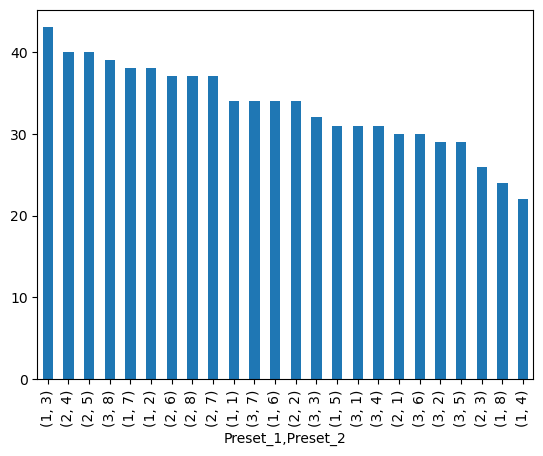

In [14]:
data[PRESETS].value_counts().plot(kind="bar")

In [15]:
data[TARGET].mean()

np.float64(0.0825)

- Columns are full filled without any nulls. 
- The rate of failure is approximately 8%
- Preset_1 (3) and Preset_2 (8) has 24 possible combinations
- Total of rows: 800
- The size of each combination varying and it is not uniform 

### Univariate Analysis 

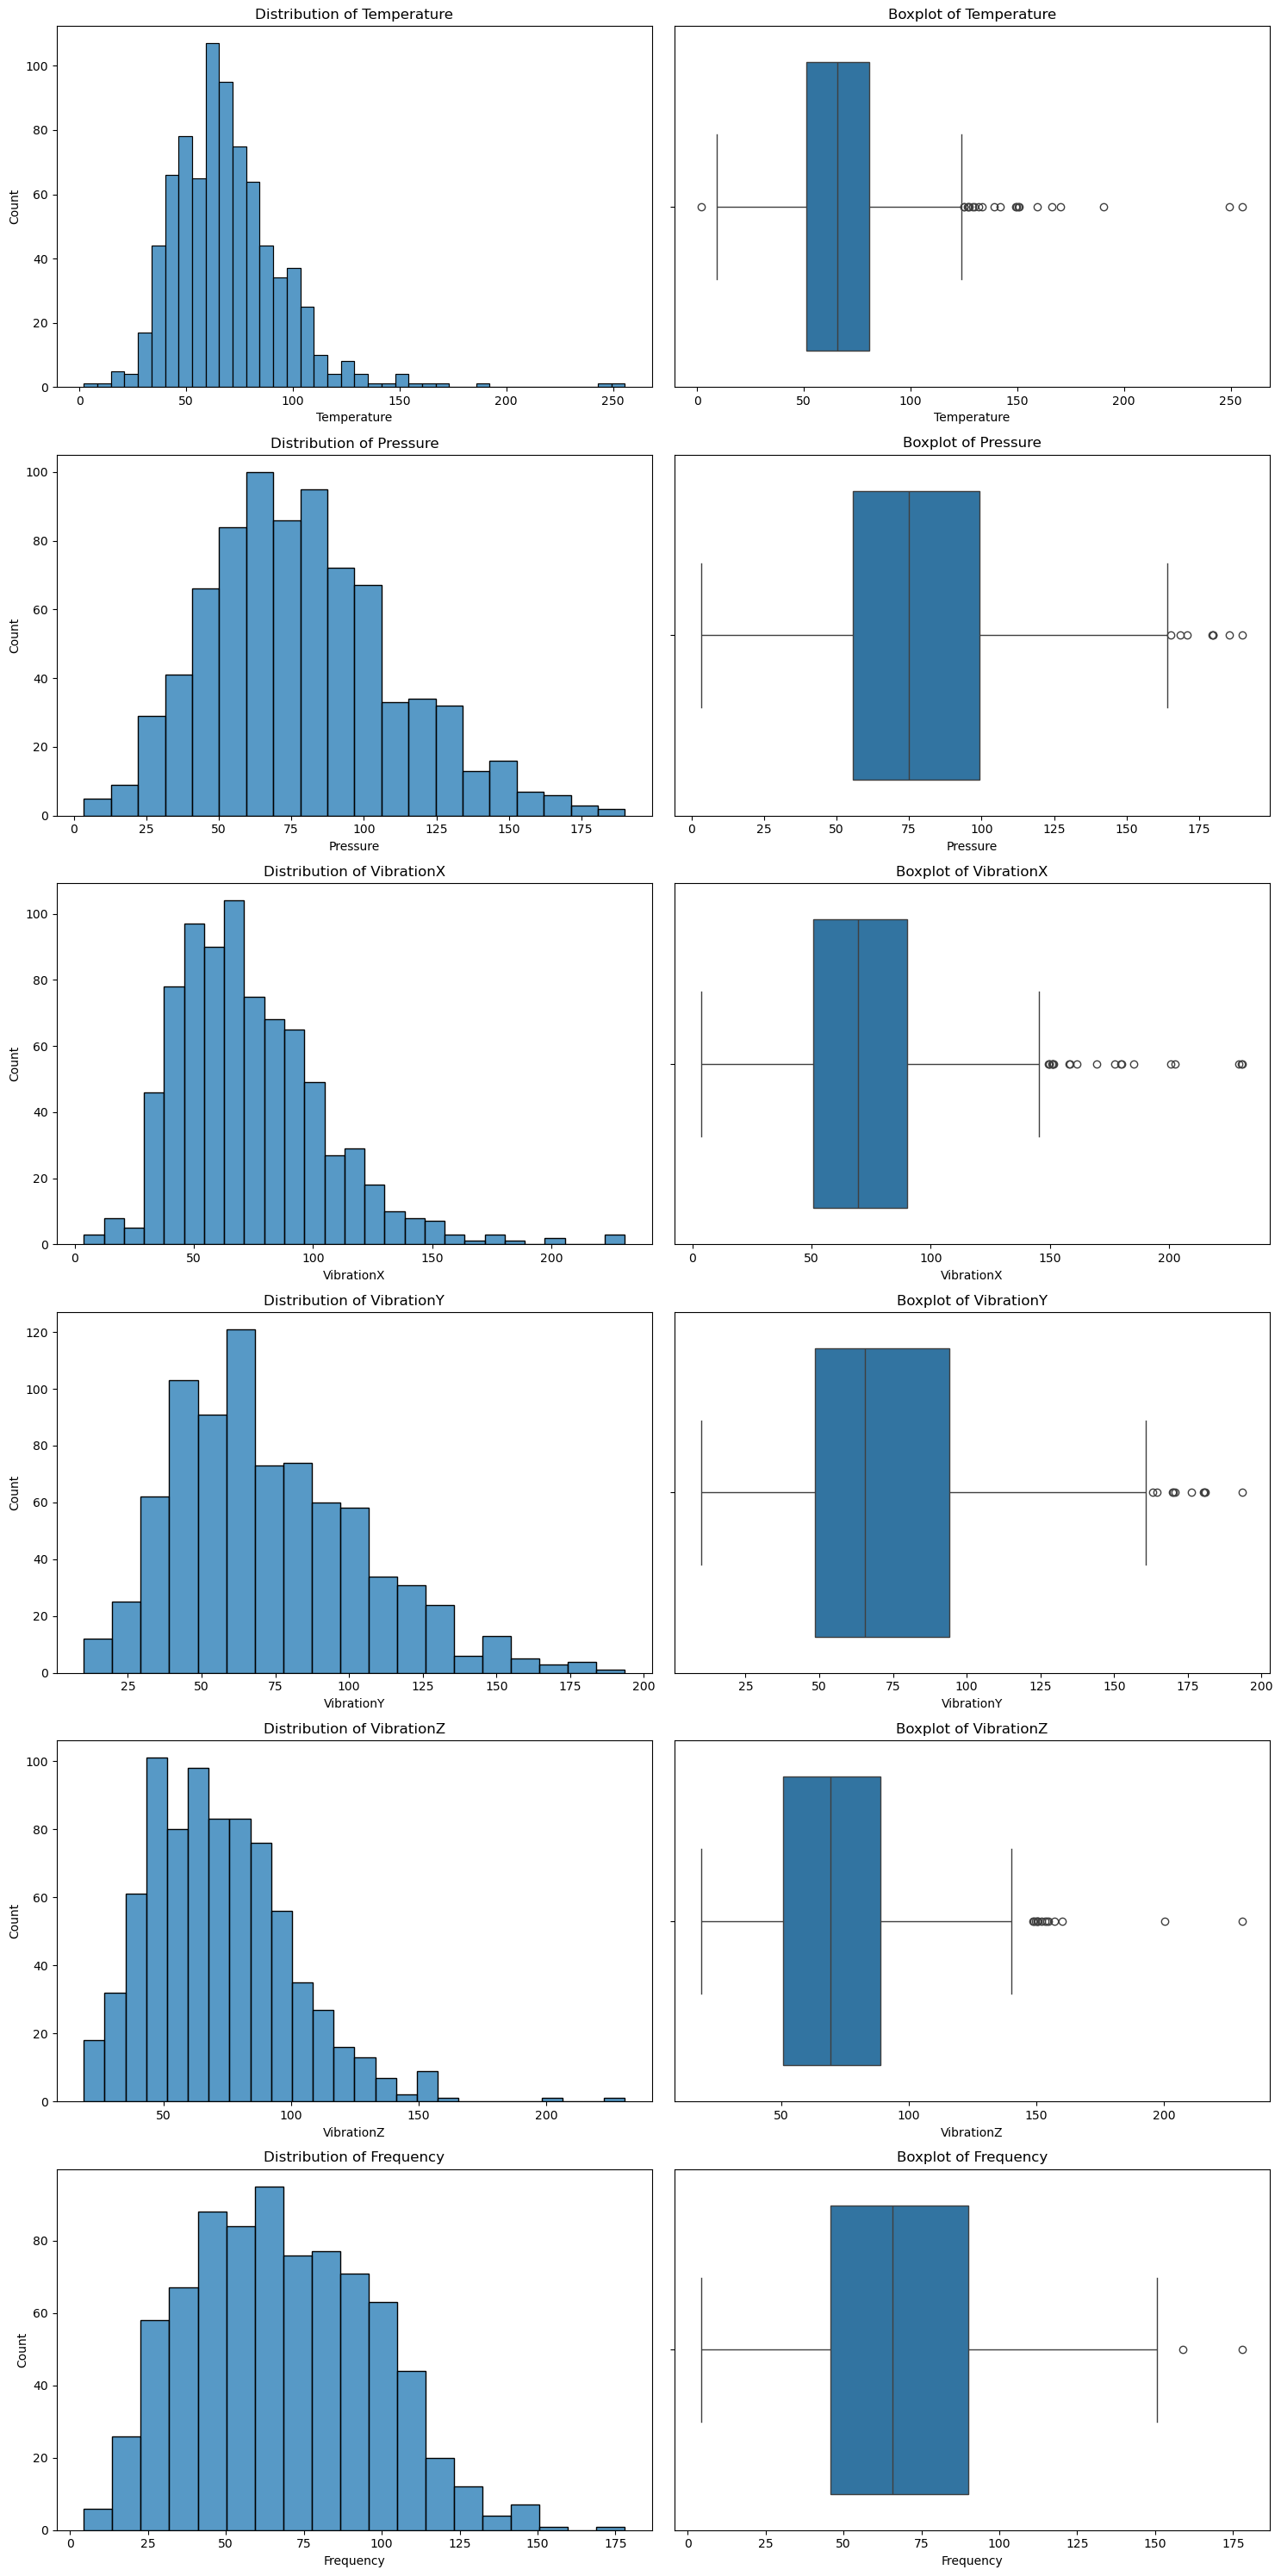

In [16]:
total_features = len(FEATURES)

fig, axs = plt.subplots(nrows=total_features, ncols=2, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.histplot(data=data, x=feature, ax=axs[index * 2])
    axs[index * 2].set_title(f"Distribution of {feature}")

    sns.boxplot(data=data, x=feature, ax=axs[index * 2 + 1])
    axs[index * 2 + 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

- Frquency is the variable with the least numbers of outliers data
- Temperature and VibrationX seems to have the high number of outliers data
- All colums have outliers
- Columns seems to have bell shaped normality distribution 

### Bivariate Analysis 

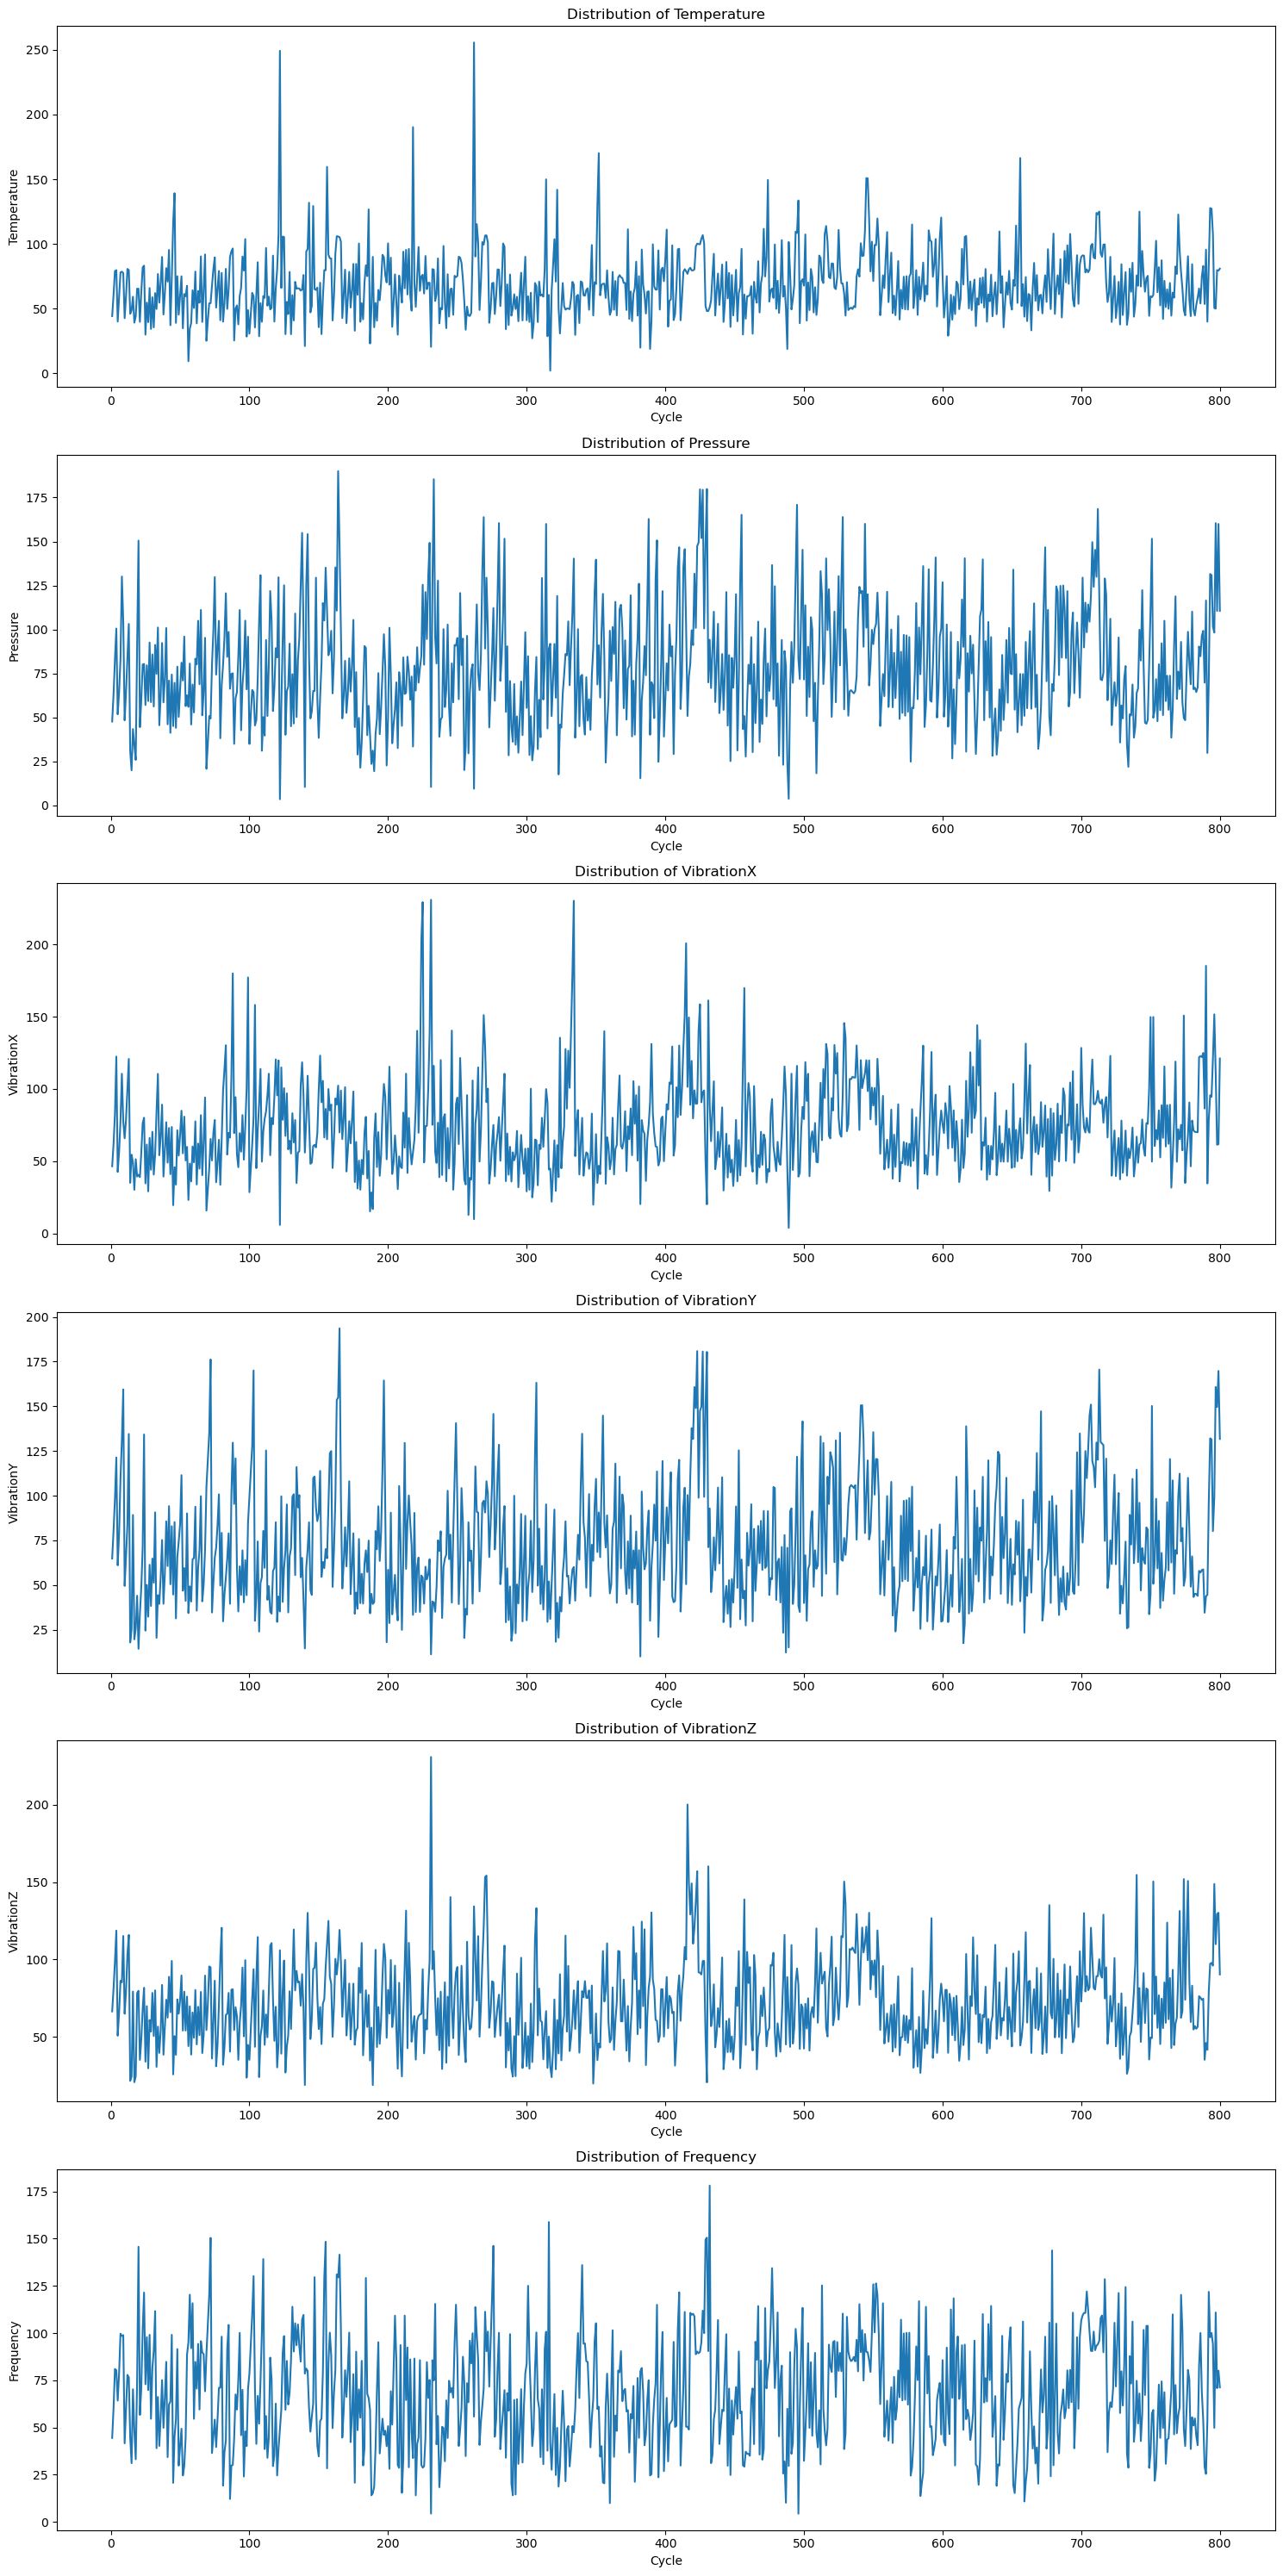

In [17]:
fig, axs = plt.subplots(nrows=total_features, ncols=1, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.lineplot(data=data, x=TIMESTAMP, y=feature, ax=axs[index])
    axs[index].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

- All variables have some peaks
- All of them seems to be stationary time series 

<Axes: xlabel='Preset_1,Preset_2'>

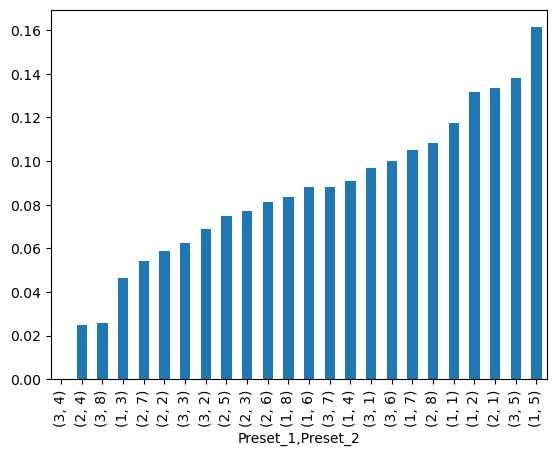

In [18]:
data.groupby(PRESETS)[TARGET].mean().sort_values().plot(kind='bar')

- Distribution of fail based on combinations of presets is not uniform
- Some combinations of presets like (1,5) has high chance to fail when in operation. In contrast, combination (3,4) almost does not fail.

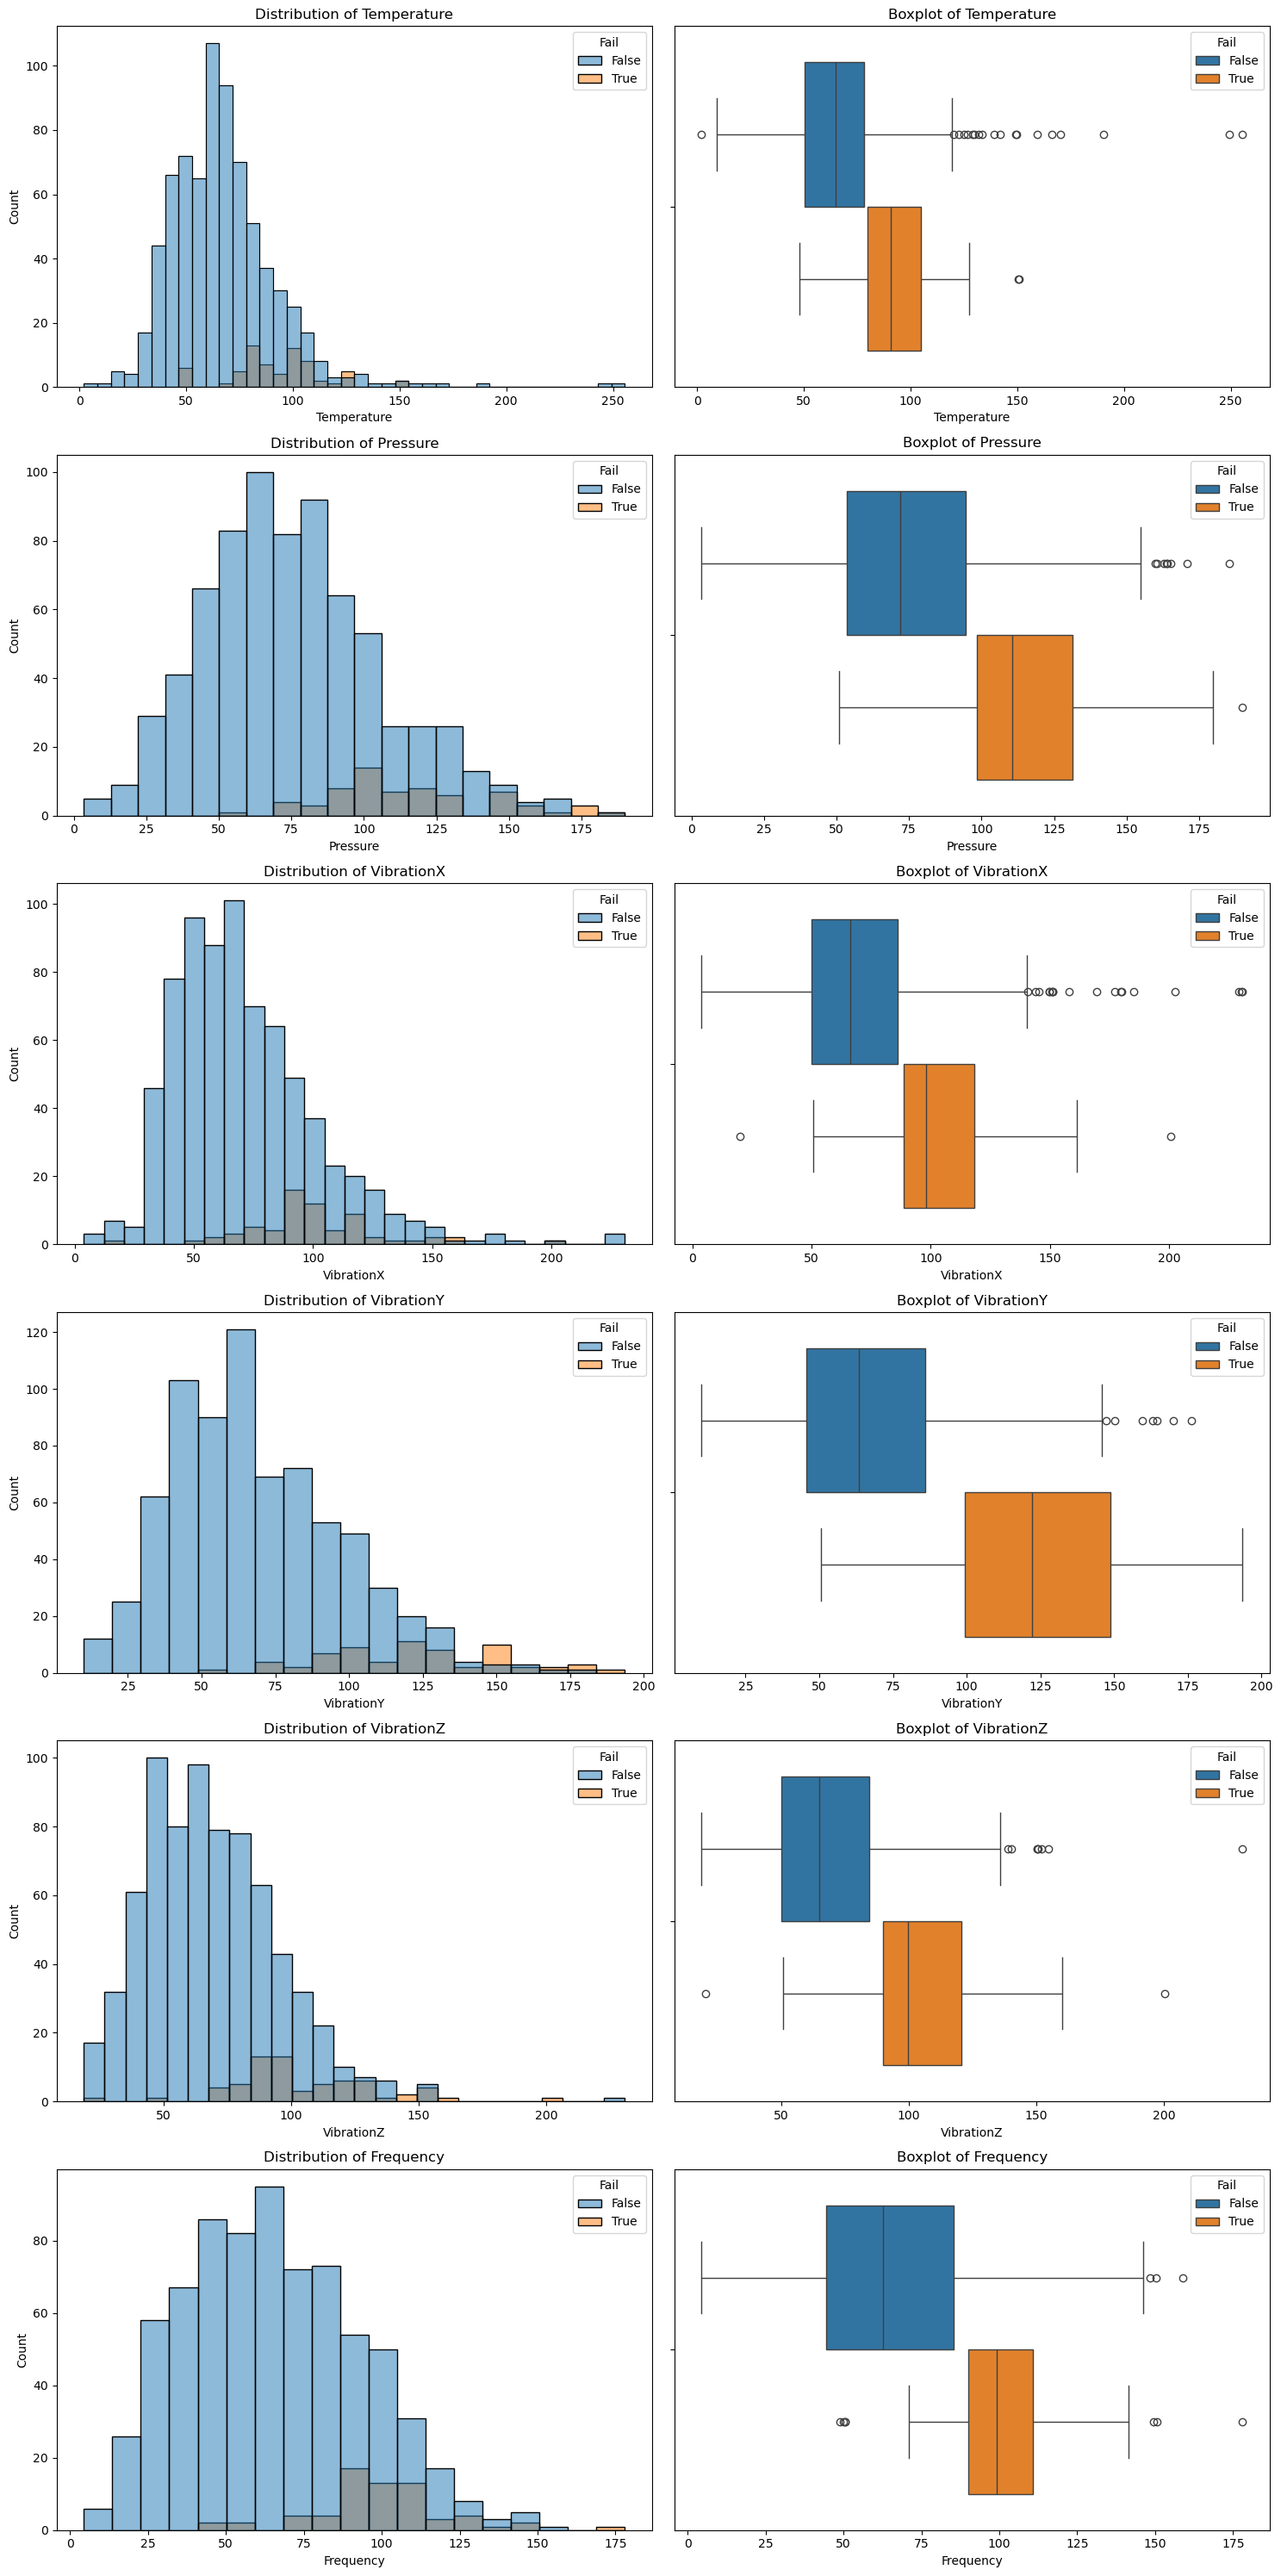

In [19]:
total_features = len(FEATURES)

fig, axs = plt.subplots(nrows=total_features, ncols=2, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.histplot(data=data, x=feature, ax=axs[index * 2], hue=TARGET)
    axs[index * 2].set_title(f"Distribution of {feature}")

    sns.boxplot(data=data, x=feature, ax=axs[index * 2 + 1], hue=TARGET)
    axs[index * 2 + 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

- Boxplots above show that are a clear division between fail or not fail regarding the distribution of the columns
- When target fail is True, most of the columns have high values when compared to False
- The most separeted data distribution between True and False is **VibrationY**

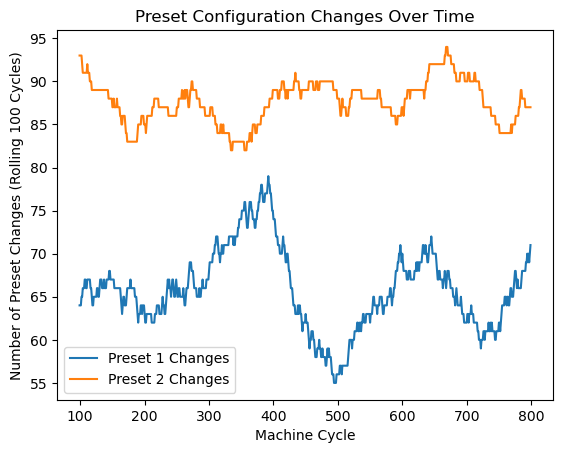

In [20]:
data['preset_1_change'] = (data["Preset_1"] != data["Preset_1"].shift(1)).astype(int)
data['preset_2_change'] = (data["Preset_2"] != data["Preset_2"].shift(1)).astype(int)
data['preset_1_change'].rolling(100).sum().plot(label="Preset 1 Changes")
data['preset_2_change'].rolling(100).sum().plot(label="Preset 2 Changes")

plt.xlabel("Machine Cycle")
plt.ylabel("Number of Preset Changes (Rolling 100 Cycles)")
plt.title("Preset Configuration Changes Over Time")
plt.legend()  # Show legend to distinguish lines

# Display the plot
plt.show()

- Preset 1 seems more constant related to changes, on the other hand, preset 2 is more volately (or the preset changes every cycle)

<Axes: >

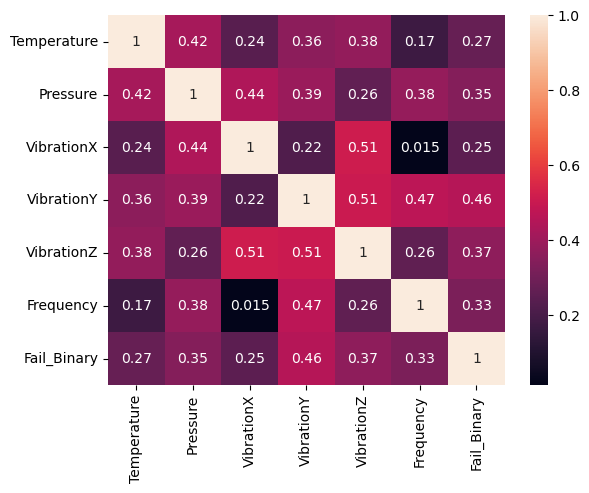

In [21]:
data['Fail_Binary'] = data[TARGET].astype(int)
sns.heatmap(data[FEATURES + ['Fail_Binary']].corr(),annot=True)

- Vibration Y has the highest correlation with the Target column (Fail_Binary)
- Vibration Z has a medium force correlation between Vibration Y and Vibration X
- Frequency and Vibration Y are also correlated, with coefficient of 0.47.

## Modelling 

### Chi-Square

The purpose here is to check if presets are independent of failure status 

In [22]:
contingency_table = pd.crosstab(data["Preset_1"], data[TARGET])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 2.07
P-value: 0.3560
Degrees of Freedom: 2


In [23]:
contingency_table = pd.crosstab(data["Preset_2"], data[TARGET])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 7.38
P-value: 0.3900
Degrees of Freedom: 7


In [24]:
contingency_table = pd.crosstab(data["Preset_2"], data["Preset_1"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 16.73
P-value: 0.2710
Degrees of Freedom: 14


- Seems that both presets do not associate with Target because both have p-value > 0.05
- Presets are also not associated between them as well

### Feature Engineering

In [25]:
data = data.sort_values(TIMESTAMP)
data = create_features(data, PRESET_LAG)
data.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,...,Frequency_lag_2_by_Preset_2,Frequency_lag_3,Frequency_lag_3_by_Preset_1,Frequency_lag_3_by_Preset_2,Frequency_lag_5,Frequency_lag_5_by_Preset_1,Frequency_lag_5_by_Preset_2,Preset_1_target_encoded,Preset_2_target_encoded,Vibration_Magnitude
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.801329
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,130.232621
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.500000,161.994313
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,...,NaN,44.483250,NaN,NaN,NaN,NaN,NaN,0.0,0.333333,209.236814
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,...,NaN,60.228715,60.228715,NaN,NaN,NaN,NaN,0.0,0.250000,90.029176


### Target

In [26]:
data[FUTURE_TARGET] = data[TARGET].shift(-C)
data.dropna(subset=[FUTURE_TARGET], inplace=True)
data[FUTURE_TARGET + "_binary"] = data[FUTURE_TARGET].astype(int)

### Train/Test 

In [27]:
columns = data.columns.tolist()
columns.remove(TIMESTAMP)
columns.remove(TARGET)
columns.remove(FUTURE_TARGET)
columns.remove(FUTURE_TARGET + "_binary")
columns.remove("Preset_1")
columns.remove("Preset_2")
columns.remove("preset_1_change")
columns.remove("preset_2_change")
columns.remove("Fail_Binary")

len(columns)

135

In [28]:
X = data[columns] 
Y = data[[FUTURE_TARGET + "_binary"]]

In [29]:
 model, test_preds, x_test, y_test, roc_auc, metrics_dict = lgb_train_test(X, Y, params=PARAMS, test_size=TEST_SIZE, threshold=THRESHOLD)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28384
[LightGBM] [Info] Number of data points in the train set: 637, number of used features: 135
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.069074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

### Inference Time

In [30]:
test_model_inference_time(len(columns), BATCH_INFERENCE_SIZE)

Average time per batch (10000 samples): 0.001438 seconds
Average time per sample: 0.000000 seconds


- Model has inference time that is approximately 1ms per sample. 

## Metrics  

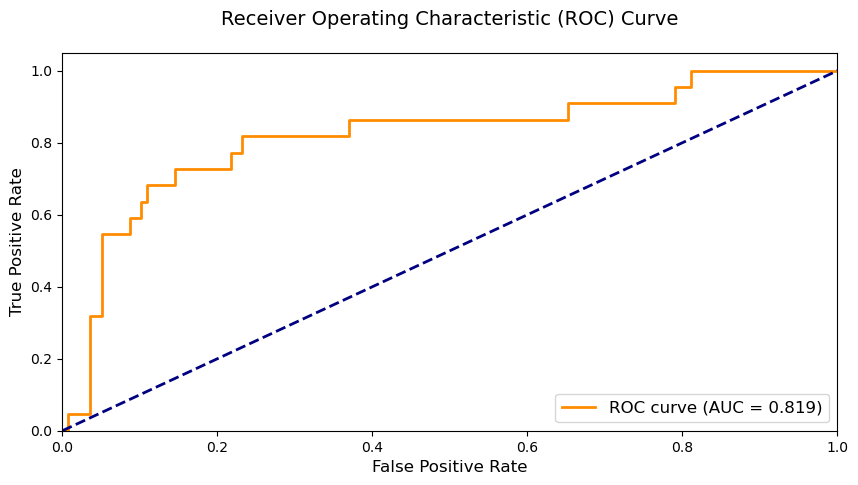

In [31]:
plot_roc_with_auc(metrics_dict)

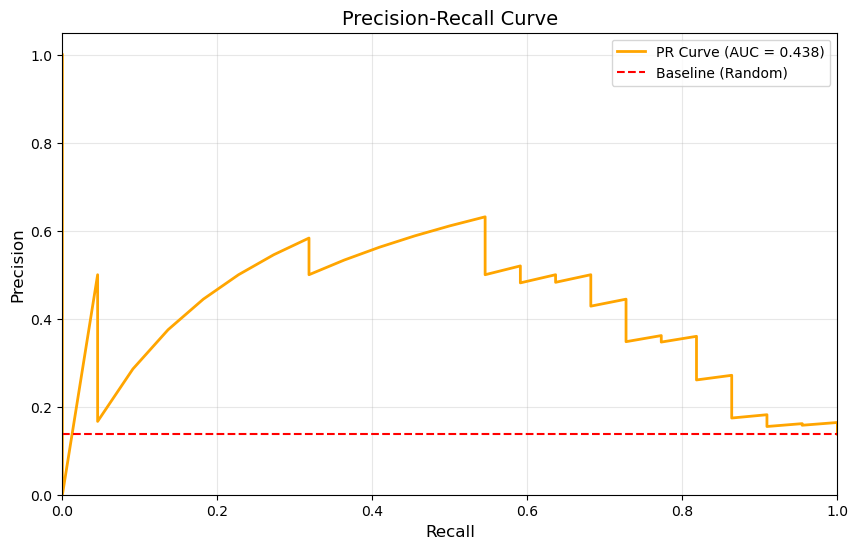

In [32]:
plot_pr_curve(metrics_dict, y_test)

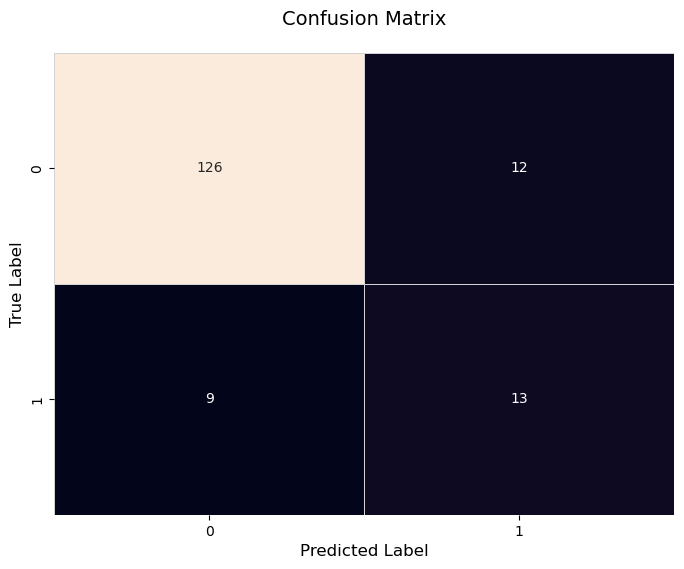

In [33]:
plot_confusion_matrix(metrics_dict)

- PR-AUC metric was selected because of the imbalanced dataset regarding fail rate. In addition we want to setup the treshold to avoid false negative which can be costly.
- Confusion matrix shows that model is worse when related to false positive than false negative.
- Maybe we have to take into account the cost regarding false positive and false negative to calculate a better treshold
- C = 3, PR-AUC = 0.44
- C = 5, PR-AUC = 0.32
- C = 10, PR-AUC = 0.16
- LightGBM is model which give good accuracy and at same time is fast regarding training phase
  - Besides that, LightGBM is very fast related to inference time if we need a fast responsive model depending on the cycle timestamp unit

## Explanation

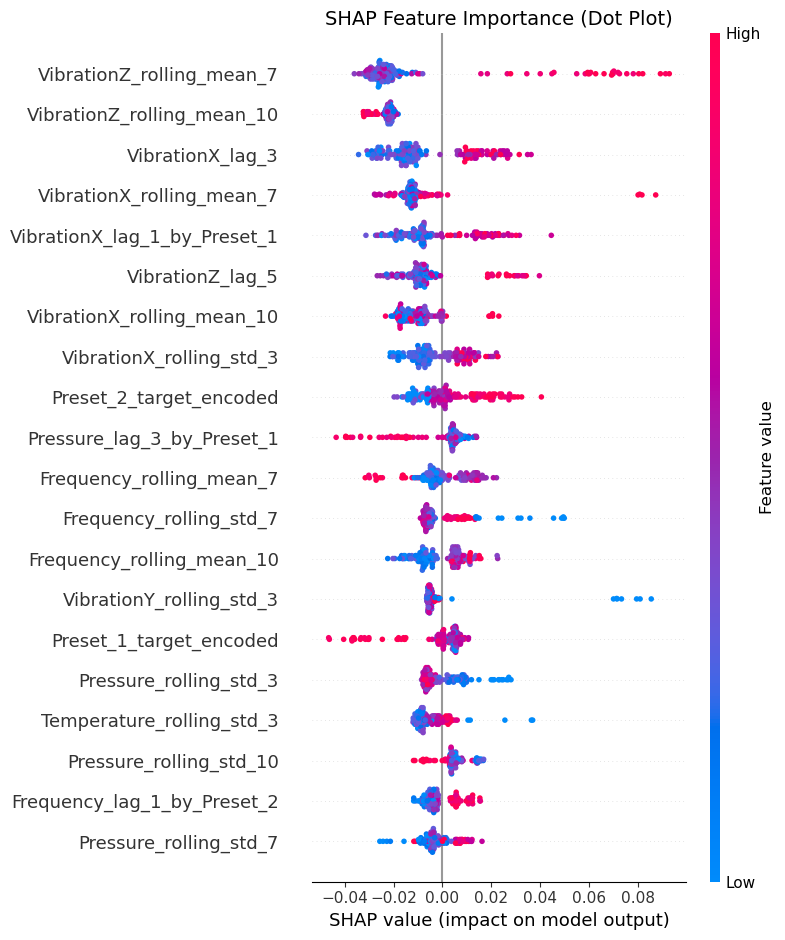

In [34]:
shap_values = shap_explainer(model, x_test, len(x_test))

- Rolling and lag features appears multiple times in top 20
- Related to pure features (without feature engineering) it doest have anyone of them on top 20
- High recent virbration levels increase failure risk. Low vibration values pull teh predction away from failure
- Rolling standard deviations behave simularly: bursts of erratic vibration are bad for operations
- VibrationX 3 days before the current day with high values shows a increasing on the model output
- Preset_2_target_encoded shows that model with high historical failure rates are likely to fail again, so some settings raise risk.
- If vibration stay high for 7-10 cycles, risk keeps climbing.

- What his means operationally:
  - Focus on vibration moniroing - especially z-axis rolling means
  - Create alert thresholds
      - A spike rule: single-cycle vfibration above X triggers inspection
      - A sustained rule: 7-cycle rolling mean above y triggers maintenance
  - Cross check presets, certain presets have high failure risk 

## Future Improvements 

- Add a Optuna (Hyperparamter Search) to find the best model hyperparamters and tune it 
- Use a cross-validation time-split to get a more robust model preserving temproal order and avoid leakage 
- Use a undersampling/oversampling approach to balance datastet while preserving critical failure patterns. Alternatively, use class weight to penalize misclassification of the minority 
- Try different types of models like (Random Forest, TreeDecision, XGBoost, CatBoost, ARIMA or LSTM)
- Add isotonic calibration above model output, so in that way model outputs probabilities (e.g, 80% score = 80% failure likelihood)
  - High risk scores related to fail can be prioritize and low risk can be postpone 
- Solve the problem with split. Splitting the train and test without good stratification can cause the following problem:
    - Train dataset does not have all the combinations of preset_1 and preset_2, so maybe, there are presets on test dataset that model don't know on you training phase 
- Add feature selection procedure using backward selection (Remove features until maximum accepted decreasing of the performance is reached) and shap feature importance 

## Deploy and Production

#### Deployment Architecture
- Containerize the model: Package the model and its dependecies into a leightweight docker container using multis-tage build process to minimize image size and security vulnerabilities.
- API Development: Develop a RESTFul API using FastAPI, leverging its asynchronous capabilities. Implement an endpoint (/predict) that accepts sensor data in JSON format via POST requests, validate inputs schemas with Pydantic, and returns model predictions with confidence scores
- Cloud Deployment: Deploy the dockerized API on AWS EC2.
    Slack Integration: Integrate the API with Slack's Incoming Webhooks to send real-time alerts to a dedicated channels when the predictions exceed a configurable risk threshold.
- Maintenance Workflow: Configure alerts to trigger maintenance tickets in the operationl team's workflow tools. <br>

#### Robust System
- Peformer end-to-end monitoring
  - Performacne Metrics: PR-AUC, precision ,recall
  - Data/Concept Drift: Use statistical tests (KS), averages and percentiles to monitore features
  - Infrastructure: Monitor API latency, error lates, and ec2 cpu/memory usage
- Retraining Pipeline:
  - Trigger: Retrain when performance drops below a threshold or montlhy
  - Validation: Use time-based cross validation to avoid leakage
  - Canary Deployment: A/B test new models in shadow mode before replacing the production

#### Operational Team Training
- Train the team to interpret prediction scores
- Allow querying predictions directly from Slack
- Conduct failure scenario simulations to refine response protocols